* Name: `dissipation-theory--Study-12.ipynb`
* Author: John A. Marohn
* Date: 2023-12-01
* Continued from: `dissipation-theory--Study-11.ipynb`
* Continued to: `dissipation-theory--Study-14.ipynb`
* Summary: Calculate dissipation versus charge density for a representive perovskite sample.

# Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dissipationtheory.constants import ureg, qe
from dissipationtheory.dissipation import CantileverModelJit, SampleModel1Jit
from dissipationtheory.dissipation import theta1norm_jit, gamma_perpendicular_jit, gamma_perpendicular_approx

In [3]:
from dissipationtheory.constants import epsilon0
from dissipationtheory.capacitance import Csphere, CsphereOverSemi

In [4]:
from lmfit import Model, Parameters

In [24]:
THIS = 'dissipation-theory--Study-12'

# Numerical computation using Lekkala and Loring's theory

Consider a semiconductor sample with

* thickness $h_{\mathrm{s}} = 300 \: \mathrm{nm}$
* complex relative dielectric constant $\epsilon_{\mathrm{s}} = 26 - 0. j$
* charge density $\rho = 1 \times 10^{14} \: \mathrm{cm}^{-3}$
* charge mobility $\mu = 8 \: \mathrm{cm}^2 \: \mathrm{V}^{-1} \mathrm{s}^{-1}$
  
and a cantilever with

* resonance frequency $f_{\mathrm{c}} = 75 \: \mathrm{kHz}$
* tip voltage $V_{\mathrm{ts}} = 1 \: \mathrm{V}$
* radius $r = 30 \: \mathrm{nm}$
* tip-sample separation $h = 40 \: \mathrm{nm}$

The semiconductor is backed by a metal, which we will model as a dielectric with relative dielectric constant $\epsilon_{\mathrm{d}} = 10^{6}$.   

Use Lekkala and Loring's `Model 1` to compute the perpendicular friction $\gamma_{\perp}$ versus charge density $\rho$.  Plot $\gamma_{\perp}$ *vs.* $\rho$ and then versus conductivity $\sigma = e \mu \rho$.

In [6]:
hs = ureg.Quantity(300, 'nanometer')  # estimated
epsilons = complex(26., 0.)           # Frost2014may, assume only real part
rho = ureg.Quantity(1e15,'cm^{-3}')   # 1e13 to 1e16 (1 to 1000 mW/cm^2)) -- Kim2018may Figure S9
mu = ureg.Quantity(8., 'cm^2/(s V)')  # Kim2018may Figure S9

fc = ureg.Quantity(75, 'kHz')       # measured
Vts = ureg.Quantity(1, 'volt')      # measured
r = ureg.Quantity(30, 'nanometer')  # spec
h = ureg.Quantity(40, 'nanometer')  # measured

Compute and print out the associated conductivity

In [7]:
sigma = (qe * mu * rho).to('S/m')
print('conductivity = {:+.2e~P}'.format(sigma.to('S/cm')))

conductivity = +1.28e-03 S/cm


Set up the simulation for a finite-thickness sample backed by a metal.

In [8]:
sample1_jit = SampleModel1Jit(
    cantilever=CantileverModelJit(
        fc.to('Hz').magnitude, 
        Vts.to('V').magnitude,  
        r.to('m').magnitude, 
        h.to('m').magnitude), 
    epsilon_s=epsilons,
    h_s=hs.to('m').magnitude,
    mu=mu.to('m^2/(s V)').magnitude,
    rho=rho.to('m^{-3}').magnitude,
    epsilon_d=complex(1.0e6, 0.),
    z_r=h.to('m').magnitude)

Simulate friction versus charge density.

In [9]:
rho_= ureg.Quantity(np.logspace(start=13, stop=16, num=50), '1/cm^3')
sigma_ = (qe * mu * rho_).to('1/(ohm m)')

In [10]:
%%time
result1 = {
    'rho': rho_,
    'sigma': sigma_,
    'gamma': ureg.Quantity(np.zeros_like(rho_), 'pN s/m')
}

for index, rho__ in enumerate(rho_):

        sample1_jit.rho = rho__.to('1/m^3').magnitude
        result1['gamma'][index] = gamma_perpendicular_jit(theta1norm_jit, sample1_jit).to('pN s/m')

CPU times: user 421 ms, sys: 7.19 ms, total: 428 ms
Wall time: 432 ms


Plot the friction versus charge density.

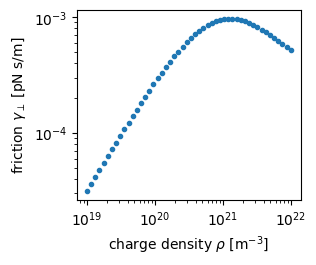

In [11]:
fig = plt.figure(figsize=(3.25, 2.75))
plt.loglog(
    result1['rho'].to('1/m^3').magnitude,
    result1['gamma'].to('pN s/m').magnitude,
    '.')
plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
plt.tight_layout()

plt.savefig(THIS + '--Fig-1.png', dpi=300)
plt.savefig(THIS + '--Fig-1.pdf')

plt.show()

# Least-squares fitting to Dwyer's model

In [12]:
def plotfit(xfit, yfit, ycalc, yerr, label_fit, label_calc, figname):

    fig, axs = plt.subplots(
        figsize=(3.25,4.00),
        nrows=2,
        sharex=True, gridspec_kw={'height_ratios': [1, 3]})
    
    dy = 100 * (yfit - ycalc)/yfit
    opts = dict(marker='o', mfc='w', ms=3, capsize=2, linestyle='none')
    
    axs[0].errorbar(xfit, dy, yerr=yerr, **opts, color='tab:blue')
    axs[0].set_ylabel('resid. [%]')
    
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].plot(xfit, ycalc, 'k-', label=label_calc)
    axs[1].errorbar(xfit, yfit, yerr=yerr, **opts, color='tab:blue', label=label_fit)

    plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
    plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
    plt.legend(frameon=False)
    
    fig.align_ylabels()
    plt.tight_layout()
    
    plt.savefig(THIS + '--' + figname, dpi=300)
    plt.savefig(THIS + '--' + figname + '.pdf')
    
    plt.show()

Make an array of sample heights that is just one element long. Do this because the function `CphereOverSemi` expects an array of heights.  Compute the capacitance for a sphere over a semi-infinite semiconductor.

In [13]:
h_ = ureg.Quantity(np.array([h.to('m').magnitude]), 'm') 
c0s = CsphereOverSemi(0, height=h_, radius=r, epsilon=epsilons.real, nterm=21)
c1s = CsphereOverSemi(1, height=h_, radius=r, epsilon=epsilons.real, nterm=21)

Make the ansatz that $R_{\mathrm{s}} = 1/(k_R \sigma_{\mathrm{s}})$ and $C_{\mathrm{s}} = \epsilon_0 k_C$, where $k_R$ and $k_C$ each have units of length.  Fit the Lekkala simulation of friction $\gamma_{\perp}^{V}$ versus conductivity $\sigma$ to Dwyer's functional form:
\begin{equation}
\gamma_{\perp}^{V} = \frac{c_1^2 k_R \sigma}{k_R^2 \sigma^2 + \omega^2 \epsilon_0^2 k_C^2}, 
\end{equation}
treating $k_R$ and $k_C$ as free parameters.

In [14]:
def fitfunc(rho_unitless, kR_unitless, kC_unitless): 
    
    rho = ureg.Quantity(rho_unitless, '1/m^3')
    kR = ureg.Quantity(kR_unitless, 'm')
    kC = ureg.Quantity(kC_unitless, 'm')
    omega = 2 * np.pi * fc
    sigma = qe * mu * rho
    gamma = (c1s**2 * Vts**2 * sigma * kR)/(sigma**2 * kR**2 + omega**2 * (epsilon0 * kC)**2)
    
    return gamma.to('pN s/m').magnitude

In [15]:
xfit = result1['rho'].to('1/m^3').magnitude
yfit = result1['gamma'].to('pN s/m').magnitude
yerr = 0.01 * yfit

In [16]:
gmodel = Model(fitfunc)

pars= Parameters() 
pars.add('kR_unitless', value=1e-8, min=0)
pars.add('kC_unitless', value=1e-8, min=0)

result = gmodel.fit(yfit, rho_unitless=xfit, params=pars, weights=1/yerr)

In [17]:
result

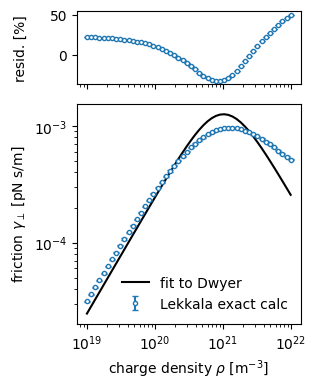

In [18]:
plotfit(xfit, yfit, result.best_fit, yerr, 'Lekkala exact calc', 'fit to Dwyer', 'Fig-2')

Compute the estimated 

In [19]:
kR_calc = np.pi * (h + r)**2 / hs 
kR_fit = ureg.Quantity(result.best_values['kR_unitless'],'m')
kC_fit = ureg.Quantity(result.best_values['kC_unitless'],'m')

In [20]:
print('kR calc = {:3.0f} nm'.format(kR_calc.to('nm').magnitude)) 
print('kR fit  = {:3.0f} nm'.format(kR_fit.to('nm').magnitude)) 

kR calc =  51 nm
kR fit  = 712 nm


In [21]:
print('kC fit  = {:3.1e} m'.format(kC_fit.to('m').magnitude)) 

kC fit  = 2.2e-02 m


In [22]:
C_fit = epsilon0 * ureg.Quantity(result.best_values['kC_unitless'],'m')

In [23]:
print('C tip = {:3.1e} F'.format(c0s[0].to('F').magnitude)) 
print('C fit = {:3.1e} F'.format(C_fit.to('F').magnitude)) 

C tip = 4.2e-18 F
C fit = 2.0e-13 F
